# 1 Examples on SD model building and simulation

In [1]:
from ASDM.ASDM import Structure
from ASDM.Utilities import plot_time_series
from IPython.display import Image

## Example 1: Goal-gap model

### Functionalities tested:
- Add stock, flow, and auxiliaries to model
- Run simulation and export the result
- Visualise simulation outcome by graph

In [2]:
class GoalGap(Structure):
    def __init__(self):
        super(GoalGap, self).__init__()
        self.add_stock("Stock", 100, in_flows=['Flow'])
        self.add_aux("Goal", 20)
        self.add_aux("Adjustment_time", 5)
        self.add_aux("Gap", "Goal-Stock")
        self.add_flow("Flow", "Gap/Adjustment_time")

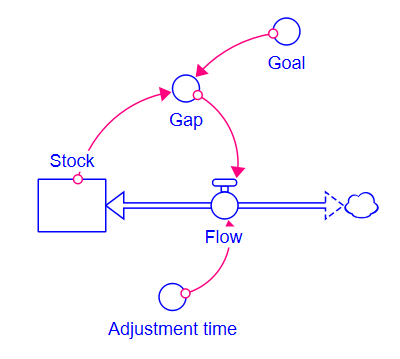

In [3]:
Image('Goal_gap_model.png')

In [4]:
goal_gap_model = GoalGap()
goal_gap_model.simulate(time=20, dt=1)
df_goal_gap = goal_gap_model.export_simulation_result()
# df_goal_gap

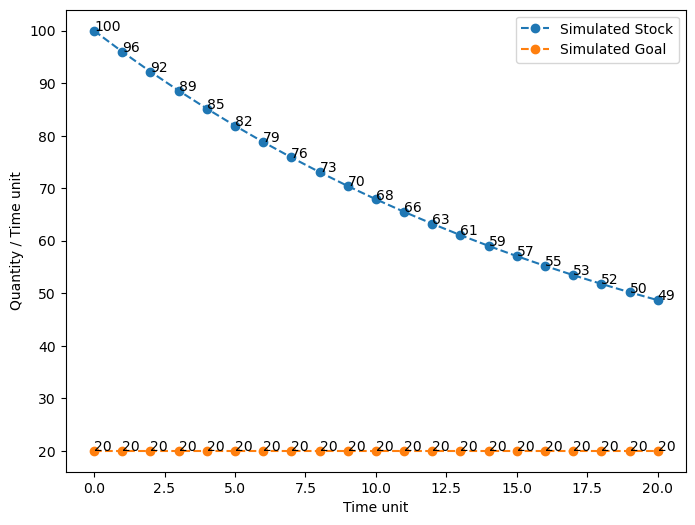

In [5]:
plot_time_series({
    "Stock":{"Simulated": df_goal_gap['Stock']},
    "Goal":{"Simulated": df_goal_gap['Goal']}
}, separate_ax=False)

## Example 2: Patient flow model

#### Functionalities tested:
- Support for non-linear functions such as MIN, MAX, enabled through built-in python functions
- Support for stochastic functions such as random binomial (rbinom), enabled through Scipy

In [6]:
class PatientFlow(Structure):
    def __init__(self):
        super(PatientFlow, self).__init__()
        self.add_stock("Waiting_list", 100, in_flows=['GP_referrals'], out_flows=['Hospital_admission_rate'])
        self.add_stock("In_hospital", 30, in_flows=['Hospital_admission_rate'], out_flows=['Treatment_completion_rate'])
        self.add_stock("In_community_care", 100, in_flows=['Treatment_completion_rate'], out_flows=['Community_care_leaving_rate'])
        
        self.add_aux("Hospital_bed_capacity", 30)
        self.add_aux("Hospital_bed_vacancy", "Hospital_bed_capacity-In_hospital")
        self.add_aux("p_completion", 0.1)
        self.add_aux("p_leaving", 0.1)

        self.add_flow("GP_referrals", 3)
        self.add_flow(
            "Hospital_admission_rate", 
            "MIN(Waiting_list, MAX(Treatment_completion_rate, Hospital_bed_vacancy))",  # mimicing the non-negative stock behaviour
            )
        self.add_flow(
            "Treatment_completion_rate", 
            "RBINOM(In_hospital, p_completion)", 
            )
        self.add_flow(
            "Community_care_leaving_rate", 
            "RBINOM(In_community_care, p_leaving)", 
            )

        # mapping SD functions to Python functions
        self.custom_functions['MAX'] = max
        self.custom_functions['MIN'] = min

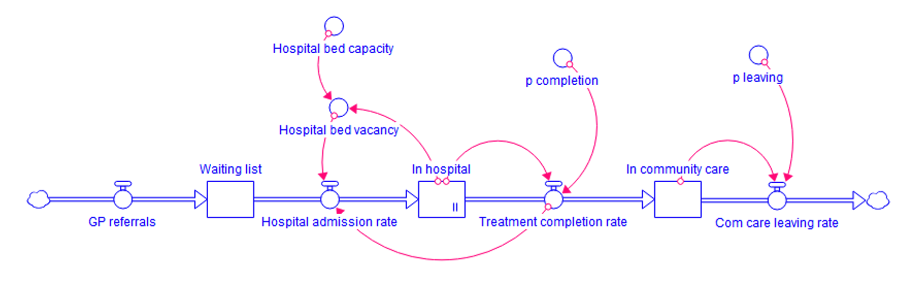

In [7]:
Image('Simplified_patient_flow_model.png')

In [8]:
patient_flow_model = PatientFlow()
patient_flow_model.clear_last_run()
patient_flow_model.simulate(time=20, dt=1)
df_patient_flow = patient_flow_model.export_simulation_result()
# df_patient_flow

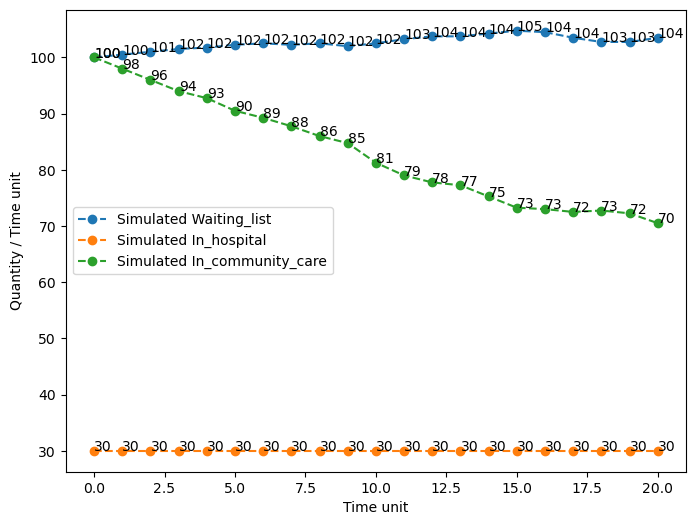

In [9]:
plot_time_series({
    "Waiting_list": {"Simulated": df_patient_flow['Waiting_list']},
    "In_hospital": {"Simulated": df_patient_flow['In_hospital']},
    "In_community_care": {"Simulated": df_patient_flow['In_community_care']}
    }, separate_ax=False)